# Regression with CART Trees

## Introduction

As we've learned, a decision tree is a supervised machine learning model that can be used both for classification and regression tasks. We have seen that a decision tree uses a tree structure to predict an output class for a given input example in a classification task. For regression analysis, each path in the tree from the root node to a leaf node represents a decision path that ends in a predicted value. In this lesson, we shall see how regression is performed in using a decision tree regressor using a simple example.  

**Note**: Kindly visit the [official documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) for the regressor tree function used in this lesson. 


## Objectives

You will be able to: 

- Explain recursive partitioning 
- Fit a decision tree regression model with scikit-learn 

## Recursive partitioning 

Linear regression is considered a __global model__ as there is a single model holding over the entire sample space. For data containing complex features with complicated and nonlinear relations, assembling such a single global model can be a very difficult and computationally expensive task. 

Another way to handle nonlinear regressions is to __partition the sample space into smaller regions__, as we have already seen in previous lessons with classification trees. This isn't much different in regression. Our goal is partition down to increasingly smaller, simpler subsets until we can fit simple regression models to them. Since each subset is a partition of a smaller subset that is itself a subset, this makes it a textbook example of **_Recursive Partioning_**.

Recall that in classification trees, the leaf nodes (the deepest nodes, or the ones at the end of each particular path) are the ones that contain the purest subsets of the data. Regression trees work a bit differently, but the general idea is still the same. With regression trees, each leaf node of the tree represents a __cell of the partition__. These cells are the smallest unit where a simple regression can be fit to the data accurately. Splitting the data still works the same way as we saw in previous lessons for classification -- we use our tree model to continuously subset down to smaller, more specific subsets until we reach a level where we can build the simplest regression model to the most specific subset in our data. For example, a regression tree may recursively partition the model down further and further until it gets all customers over the age of 50 residing in Florida with an income over \$60k/year, and then fit a simple regression model to only the data points that fit within this specific subset. 


## Simple local models

One point worth noting is that the simple regression models for each partition aren't being used as regressions in real-time. Instead, they take the sample mean of the dependent variable for that partition. Whenever the model makes a prediction, it uses this sample mean rather than calculating the actual regression model. In practice, this works quite well, and has some distinct advantages. Models are easier to interpret, and faster to use for **_inference_** (making predictions) since they are just retrieving the stored mean value rather than calculating the actual output of the regression. 

This is more easily understood when visualized. Consider the regression tree below, which predicts the price of cars based on wheelbase and horsepower:  

<img src="https://curriculum-content.s3.amazonaws.com/data-science/images/dt1.png" width=400>

Once we have created a decision tree, we can visualize the decision boundaries of that tree (assuming that the dimensionality is small enough for visualization). Notice that all the dividing lines are parallel to the axes because each internal node checks whether a single variable is above or below a given value. In simpler terms, all decision boundaries with decision trees will always be horizontal or vertical if visualized -- there are no diagonal, wavy, or curvy lines, because of the nature of the boolean (true/false) logic used by decision trees to determine the splits! 
<img src="https://curriculum-content.s3.amazonaws.com/data-science/images/dt2.png" width=400>

The tree correctly represents the interaction between Horsepower and Wheelbase, i.e. when Horsepower > 0.6, Wheelbase no longer matters. When both are equally important, the tree switches between them. 

Once we train the tree, the local models are completely understood,  so all the effort should go into finding a good partitioning of the data. 

### CART training algorithm 

In this lab, we will focus on the *CART* algorithm (Classification and Regression Trees) for *regression*. 

> The CART algorithm builds a *binary tree* in which every non-leaf node has exactly two children (corresponding to a yes/no answer). 

Given a set of training examples and their labels, the algorithm repeatedly splits the training examples $D$ into two subsets $D_{left}, D_{right}$ using some feature set $f$ and feature threshold $t_f$ such that samples with the same label are grouped together. 

At each node, the algorithm selects the split $\theta = (f, t_f)$ that produces the smallest *mean squared error* (MSE) (alternatively, we could use the mean absolute error).

So at each step, the algorithm selects the parameters $\theta$ that minimizes the following cost function:

\begin{equation}
J(D, \theta) = \frac{n_{left}}{n_{total}} MSE_{left} + \frac{n_{right}}{n_{total}} MSE_{right}
\end{equation}

- $D$: remaining training examples   
- $n_{total}$ : number of remaining training examples
- $\theta = (f, t_f)$: feature and feature threshold
- $n_{left}/n_{right}$: number of samples in the left/right subset
- $MSE_{left}/MSE_{right}$: MSE of the left/right subset

This step is repeated recursively until the *maximum allowable depth* is reached or the current number of samples $n_{total}$ drops below some minimum number. The original equations can be found [here](http://scikit-learn.org/stable/modules/tree.html).

After building the tree, new examples can be classified by navigating through the tree, testing at each node the corresponding feature until a leaf node/prediction is reached.

### Mean Squared Error (MSE)

When performing regression with CART trees (i.e. the target values are continuous) we can evaluate a split using its MSE. The MSE of node $m$ is computed as follows:

\begin{equation}
\hat{y}_m = \frac{1}{n_{m}} \sum_{i \in D_m} y_i
\end{equation}
\begin{equation}
MSE_m = \frac{1}{n_{m}} \sum_{i \in D_m} (y_i - \hat{y}_m)^2
\end{equation}

- $D_m$: training examples in node $m$
- $n_{m}$ : total number of training examples in node $m$
- $y_i$: target value of $i-$th example

Let's see the above in action with a simple experiment. We shall generate some non-linear synthetic data for our `X` and `y` attributes and fit it to a regression tree. So let's move ahead with this. In order to have a visual understanding of how this works, we shall deal with a simple regression problem between two variables `X` and `y`, where `y` is a simple function of `X` that we want to learn. Let's see this below:

## Genarate data

Run the cell below to generate the data we will be using in this lesson: 

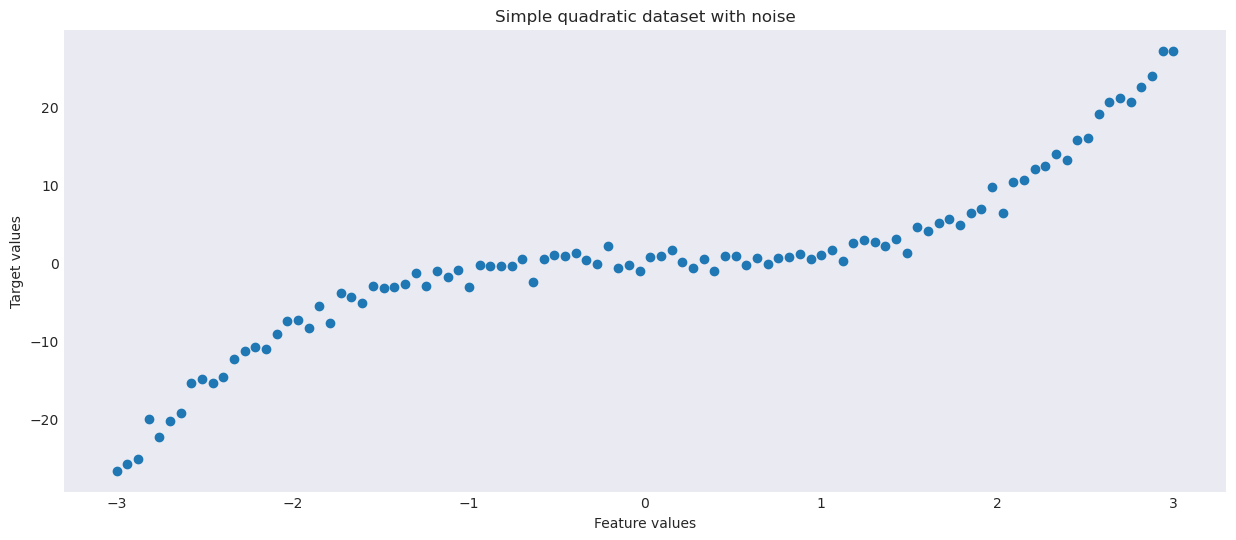

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-v0_8-dark')
np.random.seed(124)

# Generate 100 examples of X and y (a simple cubic function of X) 
X = np.linspace(-3, 3, 100)
y = X ** 3 + np.random.randn(100)

# Plot the data 
plt.figure(figsize=(15,6))
plt.scatter(X, y)
plt.title("Simple quadratic dataset with noise")
plt.xlabel("Feature values")
plt.ylabel("Target values")
plt.show()

Let's now create our features and labels, and also perform a 75/25 split for the training and test sets: 

In [2]:
X = X.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Print the data dimensions
print('Shape X_train:', X_train.shape)
print('Shape y_train:', y_train.shape)
print('Shape X_test:', X_test.shape)
print('Shape y_test:', y_test.shape)

Shape X_train: (75, 1)
Shape y_train: (75,)
Shape X_test: (25, 1)
Shape y_test: (25,)


## Fit a Regression tree

You can use `DecisionTreeRegressor()` to fit a decision tree regressor in Scikit-learn. Let's create an instance of this class just like the classification tasks and fit it to data. For now, we'll set the max depth parameter to 3, as we now know that increasing this could lead to overfitting. We can experiment with different depths later. 

In [3]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=42, max_depth=3)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

## Prediction and evaluation

The output of the cell above shows us the default values for most hyperparameters. You are encouraged to check the official documentation for this class for details on options available to you for growing regression trees! 

We can now predict labels with previously unseen data and calculate MSE. As an extra measure, we can also look at calculating the R-squared value to inspect the goodness of fit for our model. 

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Make predictions and evaluate 
y_pred = regressor.predict(X_test)
print('MSE score:', mse(y_test, y_pred))
print('R-sq score:', r2_score(y_test,y_pred))

MSE score: 7.651234359344747
R-sq score: 0.9134119360857194


## Visualize the model fit

Our R-squared score tells us that this appears to be a very good fit (remember $r^2$ ranges from 0 (poor) to 1 (best)). Let's visualize the learned function below with our scatter plot from earlier and see how well it fits.

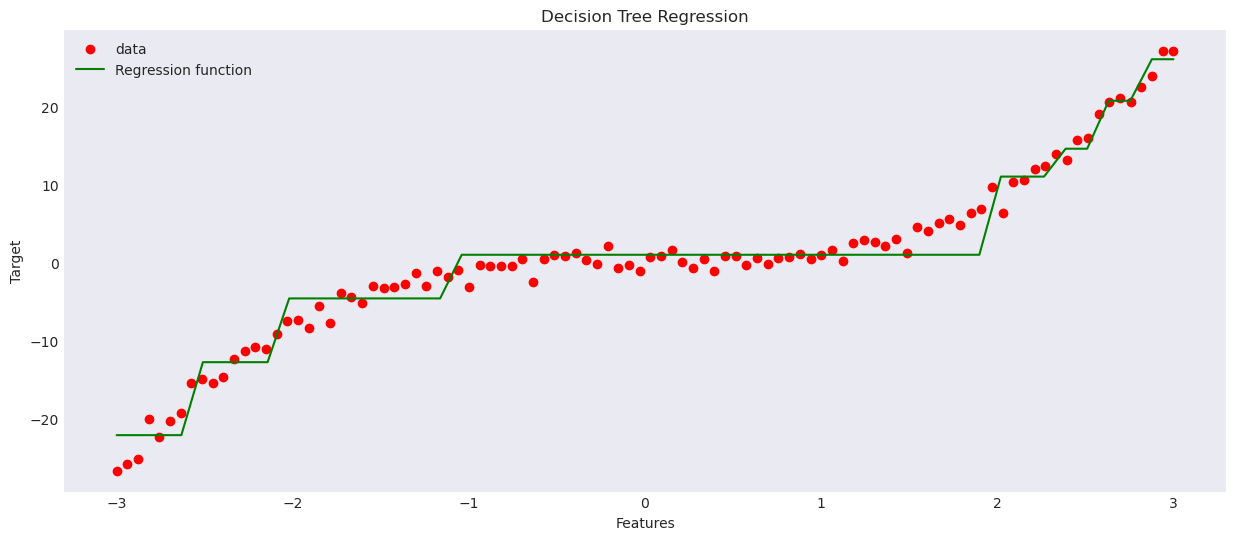

In [5]:
X_grid = np.linspace(min(X), max(X))
X_grid = X_grid.reshape((len(X_grid), 1))
plt.figure(figsize=(15,6))
plt.scatter(X, y, color = 'red', label='data')
plt.plot(X_grid, regressor.predict(X_grid), color = 'green', label='Regression function')
plt.title('Decision Tree Regression')
plt.xlabel('Features')
plt.ylabel('Target')
plt.legend()
plt.show()

In [6]:
y_pred

array([ 10.999293  ,   0.97292515,   0.97292515,   0.97292515,
         0.97292515,   0.97292515,  -4.62634507,   0.97292515,
       -12.80503148, -22.16544885,  -4.62634507,  -4.62634507,
         0.97292515,   0.97292515,  14.57622431, -22.16544885,
         0.97292515,   0.97292515, -12.80503148,   0.97292515,
         0.97292515,  10.999293  ,  -4.62634507,   0.97292515,
         0.97292515])

We found this regression line without using any complex non-linear functions, in a fraction of time. This is the key benefit of regression trees over other regression techniques that we have seen earlier. 

### Some observations

- The function is not continuous 
- Horizontal lines are averages of all data points in sections created 
- These horizontal lines represent sections. Predictions are averages of data points in these sections. So prediction for all values from the same section will be the same 

__Try changing the `max_depth` parameter in the model and grow the tree again. The resulting visualization will clearly show you the impact of tree depth on overfitting.__

## Caveats

Without **regularization**, decision trees are likely to overfit the training examples. This can be prevented using techniques like *pruning* or by providing a maximum allowed tree depth and/or a minimum number of samples required to split a node further as we saw with classification. 

## Summary 

In this lesson, you learned about CART trees for regression. You looked at how the CART algorithm works, along with MSE as a loss measure which is used as a learning mechanism. You saw a simple experiment with some synthetic data where we used a tree regressor to learn a non-linear function.